In [43]:
using LinearAlgebra
using Plots, Plots.PlotMeasures
using Colors
using LaTeXStrings
using MAT
using FFTW
using GLMakie
using Statistics

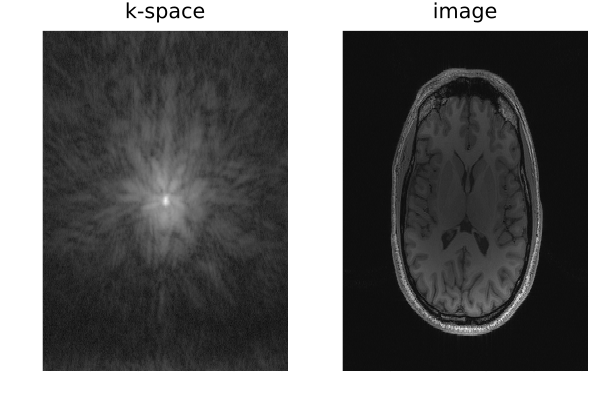

In [135]:
# load in the 2D data
kdata = 1e8 * matread("./2D_T1_human_data.mat")["kData"];
idata = fftshift(ifft(ifftshift(kdata,1:2),1:2),1:2);

# take rsos for visualization
kdata_rsos = sqrt.(sum(abs2.(kdata); dims=3))[:,:,1];
idata_rsos = sqrt.(sum(abs2.(idata); dims=3))[:,:,1];
fake_noise = maximum(idata_rsos) * randn(size(idata_rsos));

p1 = heatmap(log.(kdata_rsos), color=:grays, colorbar=false, axis=false, yflip=true, title="k-space")
p2 = heatmap(idata_rsos, color=:grays, colorbar=false, axis=false, yflip=true, title="image")

plot(p1,p2)

In [10]:
# function to define trapezoid given area, max height, and max first derivative
function trap_A(A, hmax, smax)

    # get initial height
    h = min(hmax, sqrt(A / smax))

    # get number of discrete ramp points
    nramp = ceil(Int, h / smax)

    # get number of discrete plateau points
    Aplat = A - h * nramp
    nplat = ceil(Int, max(0, Aplat / h))

    # adjust height
    h = A / (nramp + nplat)

    # form trapezoid
    trap = h / nramp * collect(1:nramp) # ramp up
    append!(trap, h * ones(nplat)) # plateau
    append!(trap, h / nramp * collect(nramp-1:-1:0)) # ramp down

    return (trap,h,nramp,nplat)
end

function trap_hl(h, l, smax)

    # get number of discrete ramp points
    nramp = ceil(Int, h / smax)

    # get number of discrete plateau points
    nplat = ceil(Int, l)

    # form trapezoid
    trap = h / nramp * collect(1:nramp) # ramp up
    append!(trap, h * ones(nplat)) # plateau
    append!(trap, h / nramp * collect(nramp-1:-1:0)) # ramp down

    return (trap,h,nramp,nplat)
end

function epi(nx,ny;ry=1,sr=0.05)

    # create frequency encode gradient
    (trap_fe,a_fe,nramp_fe,nplat_fe) = trap_hl(1,nx,sr)
    gx_fe = trap_fe
    gy_fe = zeros(length(trap_fe))
    acq_fe = vcat(zeros(length(nramp_fe)), ones(length(nplat_fe)), zeros(nramp_fe))

    # create phase encode gradient
    (trap_pe,a_pe,nramp_pe,nplat_pe) = trap_A(1/ry,1,sr)
    gx_pe = zeros(length(trap_pe))
    gy_pe = trap_pe
    acq_pe = zeros(length(trap_pe))

    # create prephaser gradient
    A_ppx = a_fe * (nplat_fe + nramp_fe) / 2
    A_ppy = (ny/ry)/2
    (trap_ppx,_,_,_) = trap_A(A_ppx,1,sr)
    (trap_ppy,_,_,_) = trap_A(A_ppy,1,sr)
    if length(trap_ppx) > length(trap_ppy)
        gx_pp = -trap_ppx
        gy_pp = vcat(-trap_ppy, zeros(length(trap_ppx) - length(trap_ppy)))
    else
        gx_pp = vcat(-trap_ppx, zeros(length(trap_ppy) - length(trap_ppx)))
        gy_pp = -trap_ppy
    end
    acq_pp = zeros(length(gx_pp))

    # build EPI trajectory
    gx_epi = gx_pp
    gy_epi = gy_pp
    acq_epi = acq_pp
    for i in 1:ny
        # frequency encode
        append!(gx_epi, (-1)^(i-1)*gx_fe)
        append!(gy_epi, gy_fe)
        append!(acq_epi, acq_fe)

        if i < ny
            # phase encode
            append!(gx_epi, gx_pe)
            append!(gy_epi, gy_pe)
            append!(acq_epi, acq_pe)
        end
    end

    return gx_epi, gy_epi, acq_epi
end

epi (generic function with 1 method)

In [44]:
# Color definitions (replace hex2rgb with RGB values or use Colors.jl if needed)
red = RGB(0x9A/255, 0x33/255, 0x24/255)
orange = RGB(0xD8/255, 0x60/255, 0x18/255)
green = RGB(0x75/255, 0x98/255, 0x8d/255)
teal = RGB(0x00/255, 0xB2/255, 0xA9/255)
blue = RGB(0x2F/255, 0x65/255, 0xA7/255)
dblue = RGB(0x00/255, 0x27/255, 0x4C/255)
amethyst = RGB(0x70/255, 0x20/255, 0x82/255)
maize = RGB(0xFF/255, 0xCB/255, 0x05/255)

In [153]:
nx = 64
ny = 16
npts = 10 # number of frames in transition animations

10

┌ Info: Saved animation to /home/djfrey/code/lps_figures/compiled_figures/epi.gif
└ @ Plots /home/djfrey/.julia/packages/Plots/Ec1L1/src/animation.jl:156


Plots.AnimatedGif("/home/djfrey/code/lps_figures/compiled_figures/epi.gif")
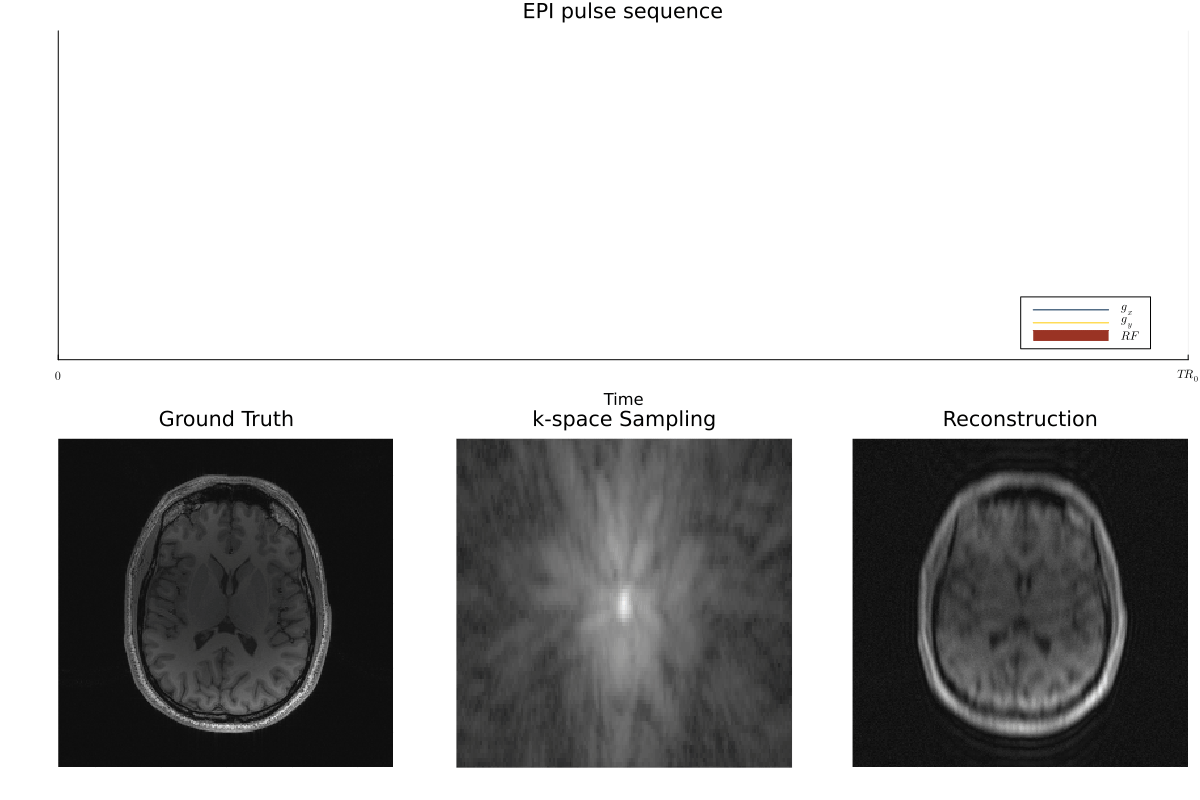

In [166]:
SNR = 1;


# create baseline EPI sequence
(gx,gy,acq) = epi(nx,ny;ry=1,sr=0.01)

# append excitation
mysinc = x -> x == 0 ? 1 : sinpi(x)/(pi*x)
rf_len = 128;
rf = vcat(mysinc.(range(-4,4,rf_len)), zeros(length(gx)))
gx = vcat(zeros(rf_len), gx)
gy = vcat(zeros(rf_len), gy)
acq = vcat(zeros(rf_len), acq)

# get the time
t = collect(0:length(gx)-1)
tr_0 = maximum(t)

anim = @animate for i = vcat(1:100:length(t), length(t))
    # plot the sequence
    pseq = plot(t[1:i], gx[1:i],
        xlim=(0,maximum(t)), ylim=(-1.1, 1.1),
        color=dblue,
        label=L"g_x",
        xticks=([0,tr_0],[L"0", L"TR_0"]),
        yticks=false,
        legend=:bottomright)
    plot!(pseq,
        t[1:i], 10*gy[1:i],
        color=maize,
        label=L"g_y",)
    plot!(pseq,
        t[1:i], rf[1:i],
        color=red,
        label=L"RF",
        yticks=false,
        fill=(0, :auto),
        xlabel="Time", ylabel="",
        title="EPI pulse sequence")

    # show the ground truth image
    X = -Int(floor(size(idata_rsos,1)/2)):Int(ceil(size(idata_rsos,1)/2))-1
    Y = -Int(floor(size(idata_rsos,2)/2)):Int(ceil(size(idata_rsos,2)/2))-1
    pgt = heatmap(X,Y,idata_rsos, color=:grays, colorbar=false, axis=false, yflip=true, title="Ground Truth")

    # plot the kspace trajectory
    kx = cumsum(gx)
    ky = 2*cumsum(gy)
    X = -Int(floor(size(kdata_rsos,1)/2)):Int(ceil(size(kdata_rsos,1)/2))-1
    Y = -Int(floor(size(kdata_rsos,2)/2)):Int(ceil(size(kdata_rsos,2)/2))-1
    pks = heatmap(X,Y,log.(kdata_rsos), color=:grays, colorbar=false, axis=false, yflip=true, xlim=(1.1*minimum(kx), 1.1*maximum(kx)), ylim=(-40,40), title="k-space Sampling")
    plot!(pks, kx[1:i], ky[1:i], color=maize, linewidth=2,label=false)

    # simulate the reconstructed image
    X = floor(Int,size(idata_rsos,1)/2) .+ (-Int(nx):Int(nx-1))
    Y = floor(Int,size(idata_rsos,2)/2) .+ (-Int(ny):Int(ny-1))
    kdata_tmp = zeros(ComplexF64,size(idata_rsos))
    kdata_tmp[Y,X] = fftshift(fft(ifftshift(idata_rsos)))[Y,X]
    idata_tmp = fftshift(ifft(ifftshift(kdata_tmp))) .+ 0.01/SNR * fake_noise
    prc = heatmap(abs.(idata_tmp), color=:grays, colorbar=false, axis=false, yflip=true, title="Reconstruction")

    psamp = plot(pgt,pks,prc,layout=(1,3))
    pall = plot(pseq,psamp,layout=(2,1),size=(1200,800))
    
end

gif(anim, "compiled_figures/epi.gif", fps=30, loop=-1)

┌ Info: Saved animation to /home/djfrey/code/lps_figures/compiled_figures/epi_res.gif
└ @ Plots /home/djfrey/.julia/packages/Plots/Ec1L1/src/animation.jl:156


Plots.AnimatedGif("/home/djfrey/code/lps_figures/compiled_figures/epi_res.gif")
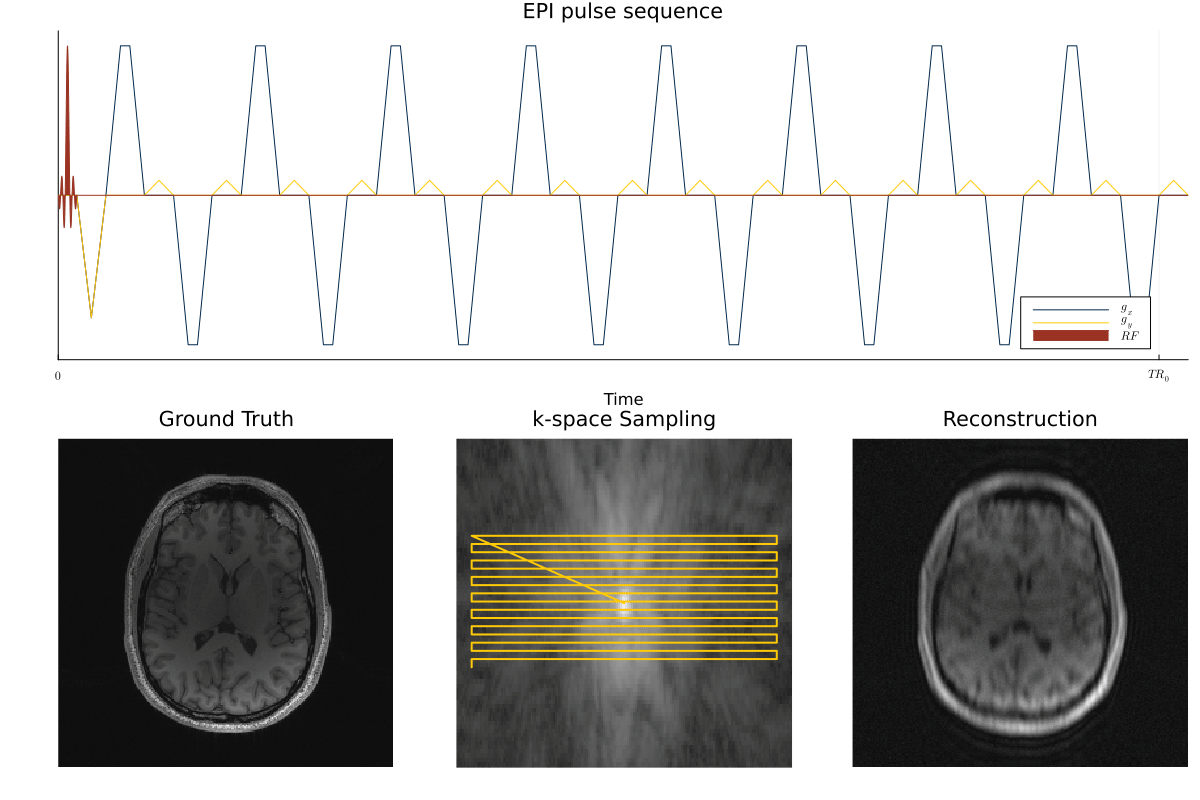

In [167]:
npts = 40

anim = @animate for i = 1:npts

    # increase the resolution
    (gx,gy,acq) = epi(nx,(1+i/npts)*ny;ry=1,sr=0.01)

    # append excitation
    mysinc = x -> x == 0 ? 1 : sinpi(x)/(pi*x)
    rf_len = 128;
    rf = vcat(mysinc.(range(-4,4,rf_len)), zeros(length(gx)))
    gx = vcat(zeros(rf_len), gx)
    gy = vcat(zeros(rf_len), gy)
    acq = vcat(zeros(rf_len), acq)

    # get the time
    t = collect(0:length(gx)-1)

    # plot the sequence
    pseq = plot(t, gx,
        xlim=(0,maximum(t)), ylim=(-1.1, 1.1),
        color=dblue,
        label=L"g_x",
        xticks=([0,tr_0],[L"0", L"TR_0"]),
        yticks=false,
        legend=:bottomright)
    plot!(pseq,
        t, 10*gy,
        color=maize,
        label=L"g_y",)
    plot!(pseq,
        t, rf,
        color=red,
        label=L"RF",
        yticks=false,
        fill=(0, :auto),
        xlabel="Time", ylabel="",
        title="EPI pulse sequence")

    # show the ground truth image
    X = -Int(floor(size(idata_rsos,1)/2)):Int(ceil(size(idata_rsos,1)/2))-1
    Y = -Int(floor(size(idata_rsos,2)/2)):Int(ceil(size(idata_rsos,2)/2))-1
    pgt = heatmap(X,Y,idata_rsos, color=:grays, colorbar=false, axis=false, yflip=true, title="Ground Truth")

    # plot the kspace trajectory
    kx = cumsum(gx)
    ky = 2*cumsum(gy)
    X = -Int(floor(size(kdata_rsos,1)/2)):Int(ceil(size(kdata_rsos,1)/2))-1
    Y = -Int(floor(size(kdata_rsos,2)/2)):Int(ceil(size(kdata_rsos,2)/2))-1
    pks = heatmap(X,Y,log.(kdata_rsos), color=:grays, colorbar=false, axis=false, yflip=true, xlim=(1.1*minimum(kx), 1.1*maximum(kx)), ylim=(-40,40), title="k-space Sampling")
    plot!(pks, kx, ky, color=maize, linewidth=2,label=false)

    # simulate the reconstructed image
    X = floor(Int,size(idata_rsos,1)/2) .+ (-Int(nx):Int(nx-1))
    Y = floor(Int,size(idata_rsos,2)/2) .+ (-ceil(Int,(1+i/npts)*ny):ceil(Int,(1+i/npts)*ny-1))
    kdata_tmp = zeros(ComplexF64,size(idata_rsos))
    kdata_tmp[Y,X] = fftshift(fft(ifftshift(idata_rsos)))[Y,X]
    idata_tmp = fftshift(ifft(ifftshift(kdata_tmp))) .+ 0.01/SNR * fake_noise
    prc = heatmap(abs.(idata_tmp), color=:grays, colorbar=false, axis=false, yflip=true, title="Reconstruction")

    psamp = plot(pgt,pks,prc,layout=(1,3))
    pall = plot(pseq,psamp,layout=(2,1),size=(1200,800))
    
end

gif(anim, "compiled_figures/epi_res.gif", fps=30, loop=-1)

┌ Info: Saved animation to /home/djfrey/code/lps_figures/compiled_figures/epi_snr.gif
└ @ Plots /home/djfrey/.julia/packages/Plots/Ec1L1/src/animation.jl:156


Plots.AnimatedGif("/home/djfrey/code/lps_figures/compiled_figures/epi_snr.gif")
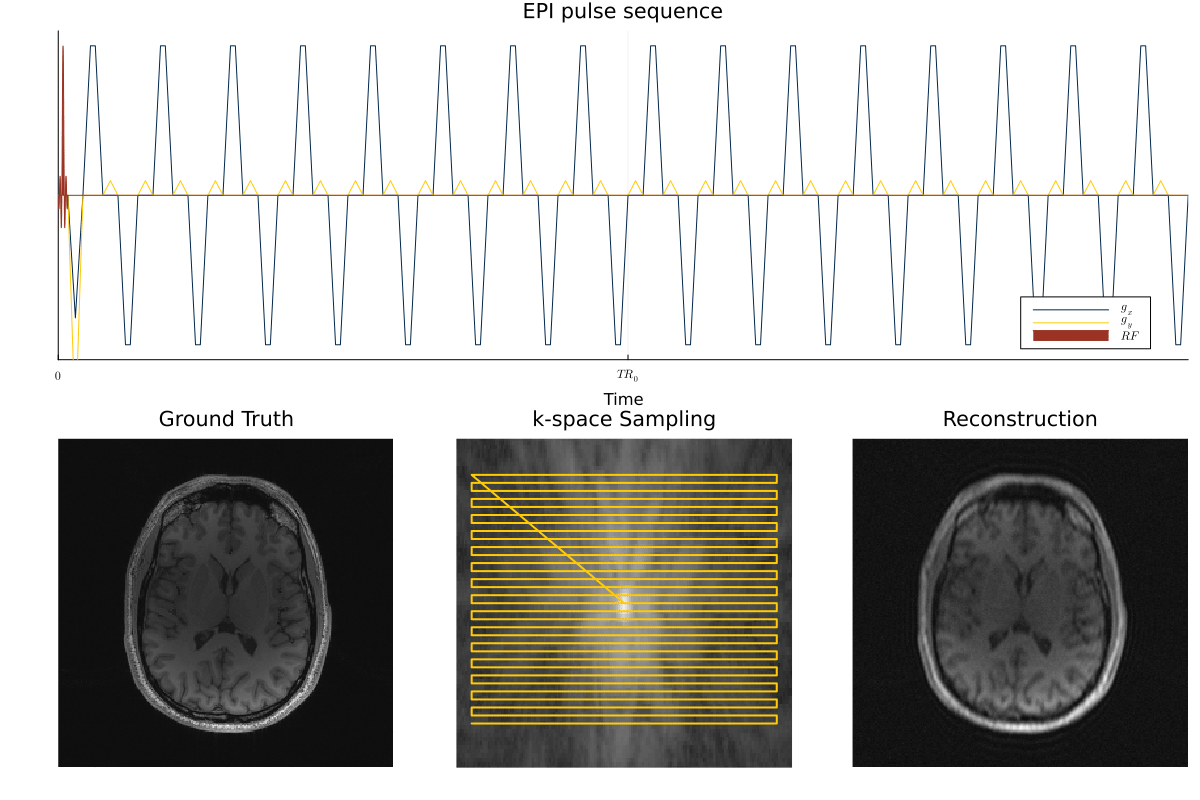

In [168]:
# reverse the resolution and boost the SNR

anim = @animate for i = 1:npts

    # increase the resolution
    (gx,gy,acq) = epi(nx,2*ny;ry=1+i/npts,sr=0.01)

    # append excitation
    mysinc = x -> x == 0 ? 1 : sinpi(x)/(pi*x)
    rf_len = 128;
    rf = vcat(mysinc.(range(-4,4,rf_len)), zeros(length(gx)))
    gx = vcat(zeros(rf_len), gx)
    gy = vcat(zeros(rf_len), gy)
    acq = vcat(zeros(rf_len), acq)

    # get the time
    t = collect(0:length(gx)-1)

    # plot the sequence
    pseq = plot(t, gx,
        xlim=(0,maximum(t)), ylim=(-1.1, 1.1),
        color=dblue,
        label=L"g_x",
        xticks=([0,tr_0],[L"0", L"TR_0"]),
        yticks=false,
        legend=:bottomright)
    plot!(pseq,
        t, 10*gy,
        color=maize,
        label=L"g_y",)
    plot!(pseq,
        t, rf,
        color=red,
        label=L"RF",
        yticks=false,
        fill=(0, :auto),
        xlabel="Time", ylabel="",
        title="EPI pulse sequence")

    # show the ground truth image
    X = -Int(floor(size(idata_rsos,1)/2)):Int(ceil(size(idata_rsos,1)/2))-1
    Y = -Int(floor(size(idata_rsos,2)/2)):Int(ceil(size(idata_rsos,2)/2))-1
    pgt = heatmap(X,Y,idata_rsos, color=:grays, colorbar=false, axis=false, yflip=true, title="Ground Truth")

    # plot the kspace trajectory
    kx = cumsum(gx)
    ky = 2*cumsum(gy)
    X = -Int(floor(size(kdata_rsos,1)/2)):Int(ceil(size(kdata_rsos,1)/2))-1
    Y = -Int(floor(size(kdata_rsos,2)/2)):Int(ceil(size(kdata_rsos,2)/2))-1
    pks = heatmap(X,Y,log.(kdata_rsos), color=:grays, colorbar=false, axis=false, yflip=true, xlim=(1.1*minimum(kx), 1.1*maximum(kx)), ylim=(-40,40), title="k-space Sampling")
    plot!(pks, kx, ky, color=maize, linewidth=2,label=false)

    # simulate the reconstructed image
    X = floor(Int,size(idata_rsos,1)/2) .+ (-Int(nx):Int(nx-1))
    Y = floor(Int,size(idata_rsos,2)/2) .+ (-ceil(Int,(2 - i/npts)*ny):ceil(Int,(2 - i/npts)*ny-1))
    kdata_tmp = zeros(ComplexF64,size(idata_rsos))
    kdata_tmp[Y,X] = fftshift(fft(ifftshift(idata_rsos)))[Y,X]
    idata_tmp = fftshift(ifft(ifftshift(kdata_tmp))) .+ 0.01/(1 + i/npts) * fake_noise
    prc = heatmap(abs.(idata_tmp), color=:grays, colorbar=false, axis=false, yflip=true, title="Reconstruction")

    psamp = plot(pgt,pks,prc,layout=(1,3))
    pall = plot(pseq,psamp,layout=(2,1),size=(1200,800))
    
end

gif(anim, "compiled_figures/epi_snr.gif", fps=30, loop=-1)

In [ ]:
function tetra(snr,sr,tr;rot=0)

    if rot = 0 # just triangle

        # plot the wireframe
        wf = [-1,0;
            0,sqrt(3);
            1,0]
        plot(wf[:,1],wf[:,2],color=:black)

    else

end

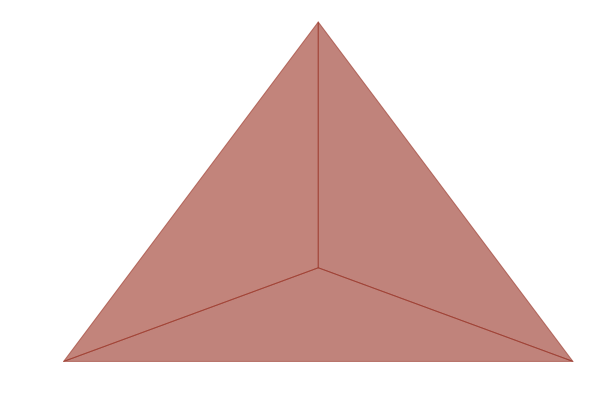

In [224]:
SNR = 0.5
sr = 0.5
tr = 0.5
theta = 5

if theta == 0 # triangles only
    wf = hcat(vcat([cos(2/3*i*pi + pi/2) for i in 1:4]...), vcat([sin(2/3*i*pi + pi/2) for i in 1:4]...))
    th = [SNR; sr; tr; SNR] .* wf
    plot(wf[:,1],wf[:,2],color=:black)
    plot!(th[:,1],th[:,2],color=red, fill=(0,:auto), alpha=0.8, grid=false,axis=false,legend=false)
else
    # base of the tetrahedron
    wf1 = [
        cos(2/3*pi + pi/2) sin(2/3*pi + pi/2);
        cos(4/3*pi + pi/2) sin(4/3*pi + pi/2);
        0 -sin(theta/180*pi);
        cos(2/3*pi + pi/2) sin(2/3*pi + pi/2)
    ]

    wf2 = [
        cos(2/3*pi + pi/2) sin(2/3*pi + pi/2);
        0 -sin(theta/180*pi);
        0 cos(theta/180*pi);
        cos(2/3*pi + pi/2) sin(2/3*pi + pi/2)
    ]

    wf3 = [
        cos(4/3*pi + pi/2) sin(4/3*pi + pi/2);
        0 -sin(theta/180*pi);
        0 cos(theta/180*pi);
        cos(4/3*pi + pi/2) sin(4/3*pi + pi/2)
    ]

    plot(wf1[:,1],wf1[:,2], color=(1-0.5*theta/90)*red, fill=(0,:auto), alpha=0.6, grid=false,axis=false,legend=false)
    plot!(wf2[:,1],wf2[:,2], color=red, fill=(0,:auto), alpha=0.6, grid=false,axis=false,legend=false)
    plot!(wf3[:,1],wf3[:,2], color=(1-0.5*theta/90)*red, fill=(0,:auto), alpha=0.6, grid=false,axis=false,legend=false)
    
end

In [ ]:

inside = [
    -SNR*cos(30/180*pi) -SNR*sin(30/180*pi);
     0 sr*sin(30/180*pi);
     tr*cos(30/180*pi) -tr*sin(30/180*pi);
     -SNR*cos(30/180*pi) -SNR*sin(30/180*pi);
]

# plot wireframe
plot(vcat(wf[:,1], wf[1,1]), vcat(wf[:,2], wf[1,2]), color=:black)

l1 = range(0,1,20) .* [cos(2/3*pi + pi/2) sin(2/3*pi + pi/2)]'
l2 = range(0,1,20) .* [cos(4/3*pi + pi/2) sin(4/3*pi + pi/2)]'
l3 = range(0,1,20) .* [cos(6/3*pi + pi/2) sin(6/3*pi + pi/2)]'

plot!(l1[:,1], l1[:,2], color=:black, line=:dash)
plot!(l2[:,1], l2[:,2], color=:black, line=:dash)
plot!(l3[:,1], l3[:,2], color=:black, line=:dash)
